In [132]:
from pprint import pprint
from tqdm import tqdm
from haystack.nodes import QuestionGenerator, ElasticsearchRetriever, FARMReader
from haystack.document_stores import ElasticsearchDocumentStore
from haystack.pipelines import (
    QuestionGenerationPipeline,
    RetrieverQuestionGenerationPipeline,
    QuestionAnswerGenerationPipeline,
)
from haystack.utils import launch_es
from haystack.document_stores import FAISSDocumentStore
from haystack.schema import Document
import nltk
from rouge import Rouge 
import numpy as np
from bs4 import BeautifulSoup
import urllib.request as urllib2
import wikipediaapi
import time
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
wiki_wiki = wikipediaapi.Wikipedia('en', extract_format=wikipediaapi.ExtractFormat.HTML)
question_generator = QuestionGenerator()
question_generation_pipeline = QuestionGenerationPipeline(question_generator)
reader = FARMReader("deepset/roberta-base-squad2")
qag_pipeline = QuestionAnswerGenerationPipeline(question_generator, reader)

Some weights of the model checkpoint at deepset/roberta-base-squad2 were not used when initializing RobertaModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
ML Logging is turned off. No parameters, metrics or artifacts will be logged to 

In [9]:
%%capture
data = []
page = wiki_wiki.page("Machine Learning")

content = [("Summary", page.summary)]
for section in page.sections:
    if section.title == "See also":
        break
    content.append((section.title, section.text))

docs_data = []
for title, text in content:
    soup = BeautifulSoup(text)
    for p in soup.find_all("p"):
        docs_data.append((title, p.text))

for i, doc in enumerate(docs_data):
    result = qag_pipeline.run(documents = [Document(content = doc[-1])])

    if len(result["results"][0]["answers"]) == 0:
        continue

    questions = [ret["query"] for ret in result["results"]]
    answers = [ret["answers"][0].answer for ret in result["results"]]
    scores = [ret["answers"][0].score for ret in result["results"]]

    data.append([questions, answers, scores])

In [217]:
q = []
a = []
s = []
for row in data:
    q_, a_, s_ = row
    q.extend(q_)
    a.extend(a_)
    s.extend(s_)
    
patterns = """

    ALL_NOUNS: {<NN>|<NNS>|<NNP>|<NNPS>|<VBG>}

    NP: {<JJ>*<ALL_NOUNS>{1,3}}
    """

NPChunker1 = nltk.RegexpParser(patterns)
stop_words = set(stopwords.words('english'))
stop_words.add("machine learning")

def treebankTag(text):
    words = nltk.word_tokenize(text)
    treebankTagger = nltk.data.load('taggers/maxent_treebank_pos_tagger/english.pickle')
    return treebankTagger.tag(words)

def prepare_text(input, chunker):    
    tagged_words = [treebankTag(input)]
    word_tree = [chunker.parse(word) for word in tagged_words]  # Identify NP chunks
    return word_tree  # Return the tagged & chunked sentences.

def return_a_list_of_NPs(text, chunker):
    
    sentences = prepare_text(text, chunker)
    
    nps = []  # an empty list in which to NPs will be stored.
    for sent in sentences:
        tree = chunker.parse(sent)
        for subtree in tree.subtrees():
            if subtree.label() == 'NP':
                t = subtree
                t = ' '.join(word for word, tag in t.leaves())
                nps.append(t)
    return nps

def getNPs(text, chunker = NPChunker1):
    NPs = return_a_list_of_NPs(text, chunker)
    return [word.lower() for word in NPs]

phrases = []
for i in range(len(q)):    
    all_phrases = getNPs(q[i]) + getNPs(a[i])
    phrases.append(all_phrases)

In [218]:
df = pd.DataFrame(data = {'questions': q, 'answers': a, 'scores': s, 'phrases': phrases})

In [219]:
df.iloc[:20]

,questions,answers,scores,phrases
0,What is the study of computer algorithms that can improve automatically thr...,Machine learning (ML),0.737251,"[study, computer algorithms, experience, use, data, machine learning, ml]"
1,Machine learning is seen as a part of what?,artificial intelligence,0.983102,"[machine learning, part, artificial intelligence]"
2,What do machine learning algorithms build a model based on?,sample data,0.766157,"[machine learning algorithms, model, sample data]"
3,What is training data used for?,make predictions or decisions,0.471450,"[training data, predictions, decisions]"
4,What are examples of applications where machine learning algorithms are used?,"medicine, email filtering, speech recognition, and computer vision",0.929899,"[examples, applications, machine learning algorithms, medicine, email filter..."
5,Where is it difficult or unfeasible to develop conventional algorithms to p...,"medicine, email filtering, speech recognition, and computer vision",0.208077,"[conventional algorithms, tasks, medicine, email filtering, speech recogniti..."
6,What is a subset of machine learning closely related to?,computational statistics,0.974674,"[subset, machine learning, computational statistics]"
7,What focuses on making predictions using computers?,computational statistics,0.981374,"[focuses, making predictions using, computers, computational statistics]"
8,"The study of mathematical optimization delivers methods, theory and applica...",machine learning,0.740033,"[study, mathematical optimization delivers methods, theory, application doma..."
9,What is a related field of study?,Data mining,0.685449,"[related field, study, data mining]"


In [215]:
df.sample(n = 10)

,questions,answers,scores,phrases,adj_score_total,adj_score_avg
106,Who found that St. George's Medical School had been using a computer?,UK's Commission for Racial Equality,0.737828,"[commission, computer, medical school, racial equality, st. george, uk, using]",6.960612,0.994373
66,What was the prize for the ensemble model that won the Grand Prize in 2009?,$1 million,0.970945,"[ensemble model, grand prize, prize]",2.912836,0.970945
31,What year was a report given on using teaching strategies?,1981,0.953974,"[report, using teaching strategies, year]",11.349631,3.783210
118,Where is there a long-standing ethical dilemma of improving health care but...,the United States,0.783985,"[improving health care, increasing profits, long-standing ethical dilemma, u...",3.135938,0.783985
42,What is a core objective of a learner?,to generalize from its experience,0.844402,"[core objective, experience, learner]",3.710695,1.236898
12,What is machine learning also referred to as in business problems?,predictive analytics,0.976467,"[business problems, machine learning, predictive analytics]",9.952934,3.317645
51,What is one way to quantify generalization error?,bias–variance decomposition,0.741848,"[bias–variance decomposition, generalization error, way]",2.330984,0.776995
68,In what year did the grand prize win?,2009,0.982913,"[grand prize win, year]",7.682477,3.841238
126,OpenAI estimated the hardware compute used in the largest deep learning pro...,"300,000-fold increase in the amount of compute required",0.070795,"[300,000-fold increase, alexnet (, alphazero (, amount, compute, deep learni...",2.860677,0.357585
55,"If the hypothesis is too complex, what happens to the model?",overfitting,0.610553,"[happens, hypothesis, model, overfitting]",6.067433,1.516858


In [174]:
phrase_score_dist = dict()

for i in range(len(df)):
    phrase_list = phrases[i]
    score = float(s[i])
    
    for phrase in phrase_list:
        dist = phrase_score_dist.get(phrase, [])
        dist.append(score)
        phrase_score_dist[phrase] = dist

In [207]:
phrase_freq = np.array(sorted([[key, len(val)] for key, val in phrase_score_dist.items()], key = lambda item: item[1], reverse = True))
phrase_total_score = np.array(sorted([[key, sum(val)] for key, val in phrase_score_dist.items()], key = lambda item: item[1], reverse = True))
phrase_total_score_dict = {key: val for key,val in phrase_total_score.tolist()}
phrase_total_score_dict["machine learning"] = 8

In [208]:
data_phrases = phrase_total_score[:, 0]
total_scores = np.asfarray(phrase_total_score[:, 1])

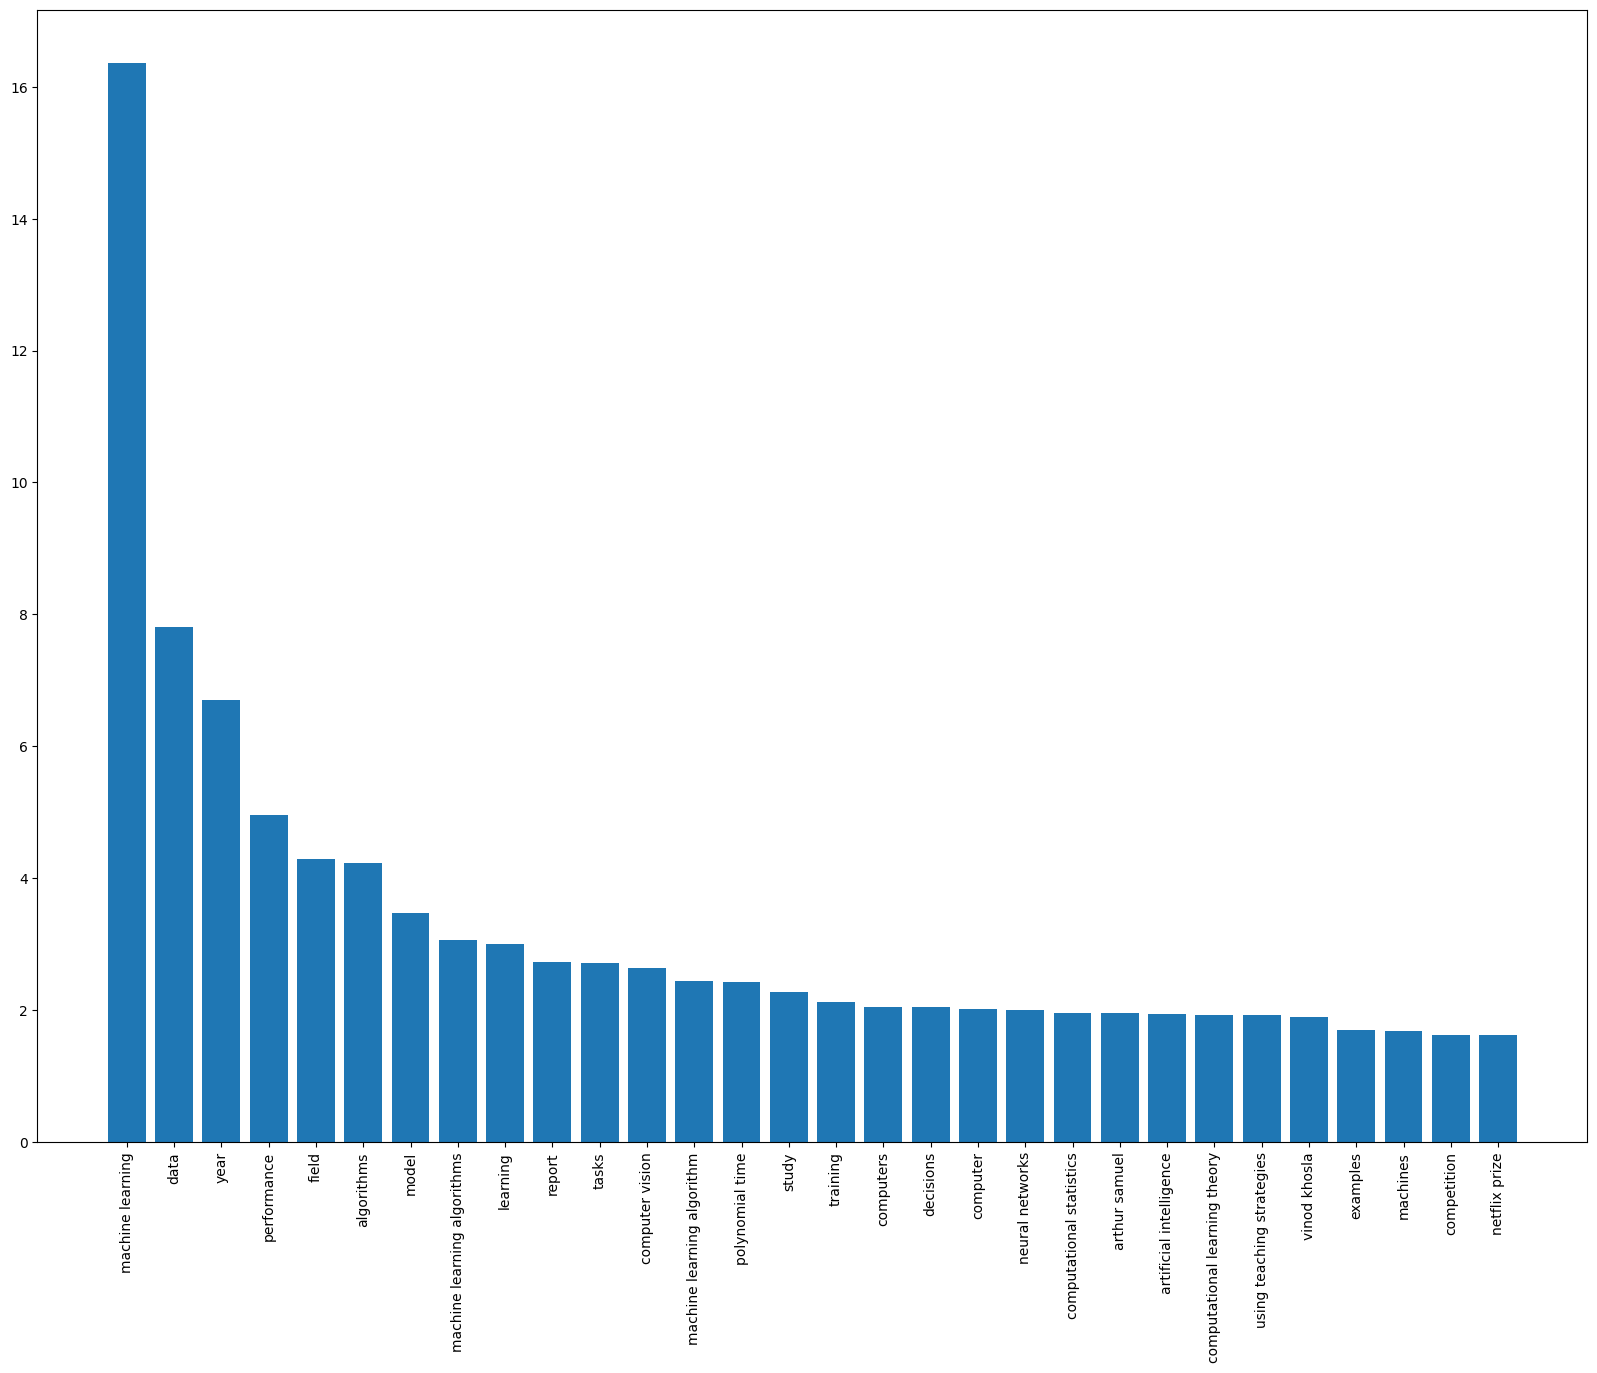

In [216]:
figure(figsize = (20, 15), dpi = 100)
plt.bar(data_phrases[:30], total_scores[:30])
plt.xticks(rotation = 90)
plt.show()

In [210]:
adj_score_total = []
adj_score_avg = []
for phrase_list in phrases:
    total_score = 0.0
    for p_ in phrase_list:
        total_score += float(phrase_total_score_dict[p_])
    adj_score_total.append(total_score)
    adj_score_avg.append(total_score / len(phrase_list))

In [211]:
df["adj_score_total"] = adj_score_total
df["adj_score_avg"] = adj_score_avg

In [212]:
df.sort_values(by = ["adj_score_total"]).iloc[:10]

,questions,answers,scores,phrases,adj_score_total,adj_score_avg
120,What do owners hold stakes in?,medication,0.154722,"[medication, owners, stakes]",1.267799,0.422600
103,What is the most common receiver operating characteristic?,ROC,0.747285,"[common receiver operating, roc]",1.494570,0.747285
108,How many candidates were denied by the computer program?,nearly 60,0.688879,"[computer program, many candidates]",1.634548,0.817274
38,How many objectives does modern day machine learning have?,two,0.872268,"[many objectives, modern day machine learning]",1.744536,0.872268
58,How many kinds of time complexity results are there?,two,0.900560,"[many kinds, time complexity results]",1.801120,0.900560
62,Machine learning approaches are traditionally divided into how many broad c...,three,0.916816,"[machine learning approaches, many broad categories]",1.833633,0.916816
116,What are other forms of ethical challenges seen in health care?,not related to personal biases,0.340165,"[ethical challenges, health care, other forms, personal biases]",1.878417,0.469604
96,What can be used to assess model accuracy?,bootstrap,0.960347,"[assess model accuracy, bootstrap]",1.920694,0.960347
100,What are ratios that fail to reveal their numerators and denominators?,false positive rate,0.340917,"[denominators, fail, false, numerators, positive rate, ratios]",2.045505,0.340917
85,What was the cause of the pedestrian's death?,after a collision,0.691629,"[cause, collision, death]",2.074887,0.691629


In [214]:
df.sort_values(by = ["adj_score_avg"], ascending = False).iloc[:10]

,questions,answers,scores,phrases,adj_score_total,adj_score_avg
80,Machine learning has been transformative in what fields?,some fields,0.363130,"[fields, machine learning]",9.181352,4.590676
77,What has been applied to predict the green behavior of human-being?,Machine learning,0.978794,"[green behavior, machine learning]",8.978794,4.489397
73,What year was it reported that a machine learning algorithm had been applie...,2014,0.830443,"[field, machine learning algorithm, year]",13.428668,4.476223
17,Machine learning involves computers learning from data provided so that the...,Machine learning,0.433513,"[certain tasks, computers learning, data, machine learning]",16.802742,4.200686
78,Machine learning is also applied to optimise what?,smartphone's performance and thermal behaviour,0.716271,"[machine learning, performance, smartphone, thermal behaviour]",16.150609,4.037652
68,In what year did the grand prize win?,2009,0.982913,"[grand prize win, year]",7.682477,3.841238
31,What year was a report given on using teaching strategies?,1981,0.953974,"[report, using teaching strategies, year]",11.349631,3.783210
30,In what year was a report given on using teaching strategies?,1981,0.966863,"[report, using teaching strategies, year]",11.349631,3.783210
6,What is a subset of machine learning closely related to?,computational statistics,0.974674,"[computational statistics, machine learning, subset]",10.930721,3.643574
1,Machine learning is seen as a part of what?,artificial intelligence,0.983102,"[artificial intelligence, machine learning, part]",10.927638,3.642546
